<a href="https://colab.research.google.com/github/GantMan/MachineLearningTraining/blob/master/Improved_Transfer_Truck_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Improved Transfer learning!

Let's see if we can do better.   We'll augment our training data, we'll add normalization, smart initialization, and even unlock the last convolutional layer.  

We'll do all this with a less sophisticated and fatter model to prove how important tuning is.  We'll be switching from the lean/clean Xception to an older model, and we'll still outperform Xception!

![Keras models available](https://i.imgur.com/FbaZLqR.png)

#### VGG-16 
*Circa 2014* - https://arxiv.org/abs/1409.1556

5 convolutional layers followed by 3 dense layers.
![VGG16](https://neurohive.io/wp-content/uploads/2018/11/vgg16.png)

In [0]:
from pathlib import Path
import numpy as np
import joblib
from keras.preprocessing import image
# Simple pre-trained model
from keras.applications import VGG16

Know that there's nothing special about the tensor order.  In some cases Theano is used (th) and for our cases TensorFlow ordering (tf) is used.  

In [0]:
from keras import backend as K
K.set_image_dim_ordering('tf') # tensor flow
# x_train will be (60000, 32, 32, 3)
# but good to know setting to 'th' in some needs
# changes x_train to (60000, 3, 32, 32)

In [0]:
from keras.datasets import cifar10
# Load data set from CIFAR-10 again
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


# We'll be separating a test set differently this time
# So let's combine back in our test data
x_train = np.concatenate((x_train, x_test))
y_train = np.concatenate((y_train, y_test))

In [26]:
x_train.shape

(60000, 32, 32, 3)

In [0]:
# adjust it so instead it sets all trucks to true and everything else to false
# broadcast boolean logic througout dataset
y_train = y_train == 9
y_test = y_test == 9
# prepare x to be normalized (between 0 and 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [0]:
x_train.shape

In [0]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(32, 32, 3)
                  )

# Let's see it
print(conv_base.summary())

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import initializers, regularizers

Sequential models don't have to use `add` over and over, just alike an array doesn't need to use `push` over and over.   You can open an array parameter to your Seqential model to  simplify the readability of the layers that you're adding.  Each item in the array is a new property.  I say `property` here, because ML experts are very particular on what is known as a "layer" or not.  Technically "Pool", "Dropout", and "Flatten" don't count.

In [0]:

model = Sequential([
    conv_base,
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01), kernel_initializer=initializers.he_normal(seed=None)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


In [0]:
print("Trainable weights = " + str(len(model.trainable_weights)))
print(model.summary())
conv_base.trainable = False
print("New trainable weights = " + str(len(model.trainable_weights)))

In [0]:
model.compile(
  loss ='binary_crossentropy',
  optimizer = 'adam',
  metrics=['accuracy']
)

Use x_train instead of features, because our model is fully built!

In [0]:
history = model.fit(
  x_train,
  y_train,
  validation_split=0.05,
  epochs=10,
  shuffle=True
)

Hrmmmmm close but not as good as we Xception could get us, even if Xception easily overfit our data!  Let's do some fine-tuning to our model

### **But first graph the previous results!**


In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.figure()

In [0]:
# Everything from block5_conv1 down becomes trainable now
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

One way we can make sure our dataset generalizes well, is by slightly changing our examples with image augmentation.  By changing the lighting, angle, saturation etc. we can pretend we took multiple photos of the same identifiable thing.

![augmentation](https://raw.githubusercontent.com/aleju/imgaug-doc/master/readme_images/examples_grid.jpg?raw=true =500x)

Data augmentation slows down the training process and usually requires that you have a GPU to reasonably process these in a speedy manner.

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
)

# Validation data should not be modified
# Unless of course you have yet to divide by 255
# in that case both training and validation can
# be normalized with `adding rescale=1./255,`
validation_datagen = ImageDataGenerator()

In [0]:
model.compile(
  loss ='binary_crossentropy',
  optimizer = 'adam',
  metrics=['accuracy']
)

We'll be generating using `.flow`, for our in-memmory data, but if your files are on disk, you can use `flow_from_directory`, which has it's own parameters and batching process into memmory.

Read more:  https://keras.io/preprocessing/image/

In [0]:
GENERATOR_BATCH_SIZE = 32

train_generator = train_datagen.flow(
  x_train, 
  y_train,
  batch_size=GENERATOR_BATCH_SIZE
)

validation_generator = validation_datagen.flow(
  x_test,
  y_test,
  batch_size=GENERATOR_BATCH_SIZE
)

In [40]:
history = model.fit_generator(
  train_generator,
  epochs=10,
  steps_per_epoch=len(x_train) / GENERATOR_BATCH_SIZE,
  shuffle=True,
  validation_data=validation_generator,
  validation_steps=len(x_train) / GENERATOR_BATCH_SIZE
)

Epoch 1/10
1875/1875 [==============================] - 105s 56ms/step - loss: 0.6754 - acc: 0.9023 - val_loss: 0.1788 - val_acc: 0.9108
Epoch 2/10
1875/1875 [==============================] - 103s 55ms/step - loss: 0.2171 - acc: 0.9115 - val_loss: 0.1660 - val_acc: 0.9317
Epoch 3/10
1875/1875 [==============================] - 102s 55ms/step - loss: 0.2019 - acc: 0.9188 - val_loss: 0.1373 - val_acc: 0.9492
Epoch 4/10
1875/1875 [==============================] - 103s 55ms/step - loss: 0.1916 - acc: 0.9262 - val_loss: 0.1315 - val_acc: 0.9521
Epoch 5/10
1875/1875 [==============================] - 103s 55ms/step - loss: 0.1853 - acc: 0.9282 - val_loss: 0.1493 - val_acc: 0.9461
Epoch 6/10
1875/1875 [==============================] - 102s 54ms/step - loss: 0.1824 - acc: 0.9285 - val_loss: 0.1230 - val_acc: 0.9548
Epoch 7/10
1875/1875 [==============================] - 101s 54ms/step - loss: 0.1813 - acc: 0.9299 - val_loss: 0.1355 - val_acc: 0.9547
Epoch 8/10
1875/1875 [===================

### Let's test

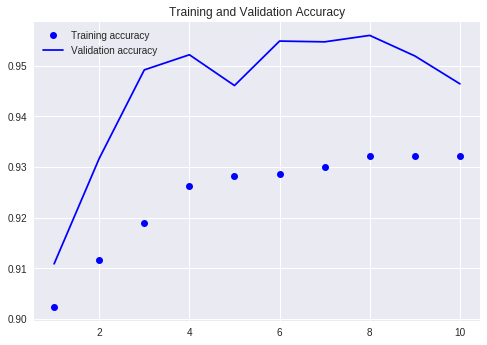

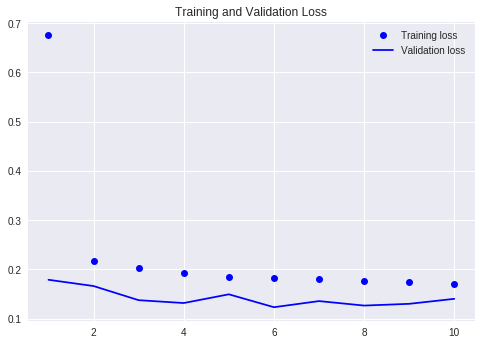

In [41]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.figure()

# SUCCESS!!!

### This smaller model has mid-nineties accuracy!   That's some serious tuning!

#### We beat a non-tuned Xception model using tuning, augmentation, and normalization.


---



## Now let's review precision and recall
![precision and recall](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/800px-Precisionrecall.svg.png =600x)

In [42]:
from sklearn.metrics import classification_report

predictions = model.predict(x_test, batch_size=32, verbose=1)
# If the model is more than 50% sure the object is a truck, call it a truck.
# Otherwise, call it "not a truck" via boolean
predictions = predictions > 0.5

# Calculate Precision and Recall for each class
report = classification_report(y_test, predictions)
print(report)

10000/10000 [==============================] - 5s 539us/step
              precision    recall  f1-score   support

       False       0.98      0.96      0.97      9000
        True       0.70      0.83      0.76      1000

   micro avg       0.95      0.95      0.95     10000
   macro avg       0.84      0.89      0.86     10000
weighted avg       0.95      0.95      0.95     10000



/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


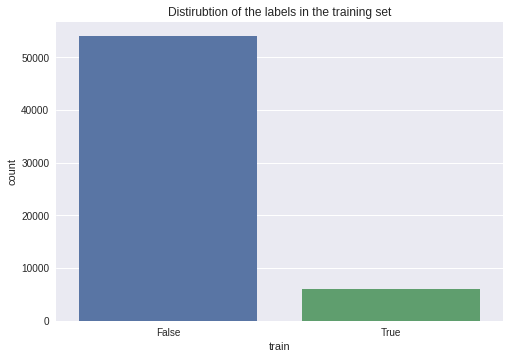

In [17]:
import pandas as pd
import seaborn as sns


train_data = {
    'train': y_train.flatten()
}

df = pd.DataFrame(train_data)
ax = sns.countplot(x = 'train', data=df).set_title("Distirubtion of the labels in the training set")

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


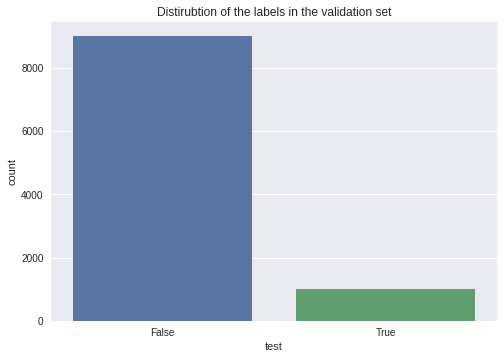

In [22]:
test_data = {
    'test': y_test.flatten()
}

df = pd.DataFrame(test_data)
ax = sns.countplot(x = 'test', data=df).set_title("Distirubtion of the labels in the validation set")

## Next steps?

Gather more truck examples, or possibly create more augmented true examples to balance out the input.  It really depends on the need.

We can now save this model for use!

In [0]:
# Save it for later
model.save("truck_classifier_model.h5")

**Even download it to your machine!**

In [0]:
from google.colab import files

files.download('truck_classifier_model.h5')